In [3]:
import os
import time
import cv2
from ultralytics import YOLO
import os
from ultralytics.utils.plotting import Annotator
import yolov7
from colorama import Fore, Style
import json 


In [4]:
def detect_fire_smoke(model_yolov8, model_yolov7, dir_path, **kwargs):
    for idx, file in enumerate(os.listdir(dir_path)):
        print(f"Processing file {idx + 1} out of {len(os.listdir(dir_path))}")
        file_path = os.path.join(dir_path, file)
        try:
            confidence = kwargs.get("confidence", 0.2)
            img = cv2.imread(file_path)
            img_size_mb = os.path.getsize(file_path) / 1e6

            st_8 = time.time()
            model_yolov8.predict(img, conf=confidence)
            end_8 = time.time()

            st_7 = time.time()
            model_yolov7(img, size=640)
            end_7 = time.time()

            results = {"yolov8_time": end_8 - st_8, "yolov7_time": end_7 - st_7, "img_size_mb": img_size_mb}
            yield {f"img_{idx}": results}
        except Exception as e:
            print(Fore.RED + f"Error in file {file_path}")
            print(e)
            print(Style.RESET_ALL)
            continue

def append_to_json_file(data, filename):
    try:
        with open(filename, 'r') as f:
            existing_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = []

    existing_data.append(data)

    with open(filename, 'w') as f:
        json.dump(existing_data, f)

def process_files(model_yolov8, model_yolov7, dir_path, **kwargs):
    start = time.time()
    json_file_path = "times/times_colab.json"
    
    for result in detect_fire_smoke(model_yolov8, model_yolov7, dir_path, **kwargs):
        append_to_json_file(result, json_file_path)
    
    print(f"Total time: {time.time() - start}")

In [ ]:
# Load YoLoV8
model_yolov8 = YOLO("models/yolov8/weights/fire_model.pt")
# Load YoLoV7
model_yolov7 = yolov7.load("models/yolov7/runs/train/exp/weights/best.pt")
# Confidence
confidence = 0.2
model_yolov7.conf = confidence

In [ ]:
dir_path = "custom_dataset_with_fire_images"
#os.mkdir("times")
times = []
start = time.time()
process_files(model_yolov8, model_yolov7, dir_path, confidence=0.2)
print(f"Total time: {time.time() - start}")
            

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
data = json.load(open('times/times.json'))
c_data  = []
for img in data:
    key = img.keys().__iter__().__next__()
    c_data.append(img[key])
df = pd.DataFrame(c_data)
print(df.shape)
df.head(2)

(2135, 3)


,yolov8_time,yolov7_time,img_size_mb
0,19.482357,2.230658,0.186307
1,0.144694,1.623507,0.008701


In [4]:
# Remove max outlier values
df = df[df.yolov8_time != df.yolov8_time.max()]
df = df[df.yolov7_time != df.yolov7_time.max()]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
yolov8_time,2133.0,0.046519,0.012151,0.027490,0.039618,0.044353,0.050494,0.249012
yolov7_time,2133.0,1.735319,0.604496,0.521745,1.278429,1.548028,2.102771,5.357866
img_size_mb,2133.0,0.072472,0.356215,0.001939,0.006920,0.010261,0.019640,8.354004


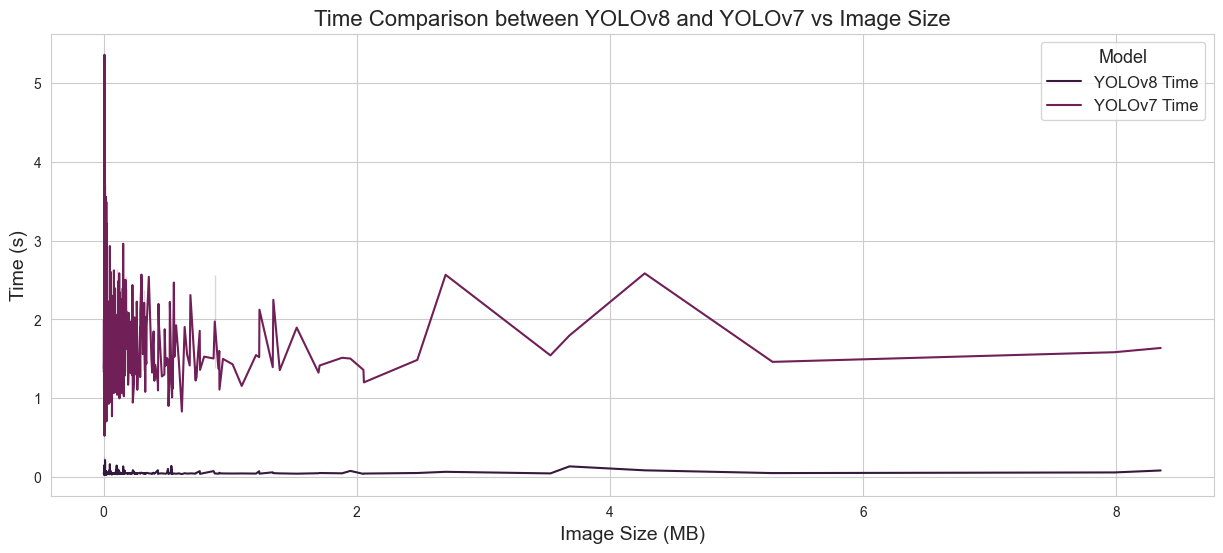

In [6]:
# Line Plot
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid") 
sns.set_palette("rocket") 
sns.lineplot(data=df, x='img_size_mb', y='yolov8_time', label='YOLOv8 Time', linewidth=1.5)
sns.lineplot(data=df, x='img_size_mb', y='yolov7_time', label='YOLOv7 Time', linewidth=1.5)
plt.xlabel('Image Size (MB)', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.title('Time Comparison between YOLOv8 and YOLOv7 vs Image Size', fontsize=16)
plt.grid(True)
plt.legend(title='Model', title_fontsize='13', fontsize='12')

plt.show()


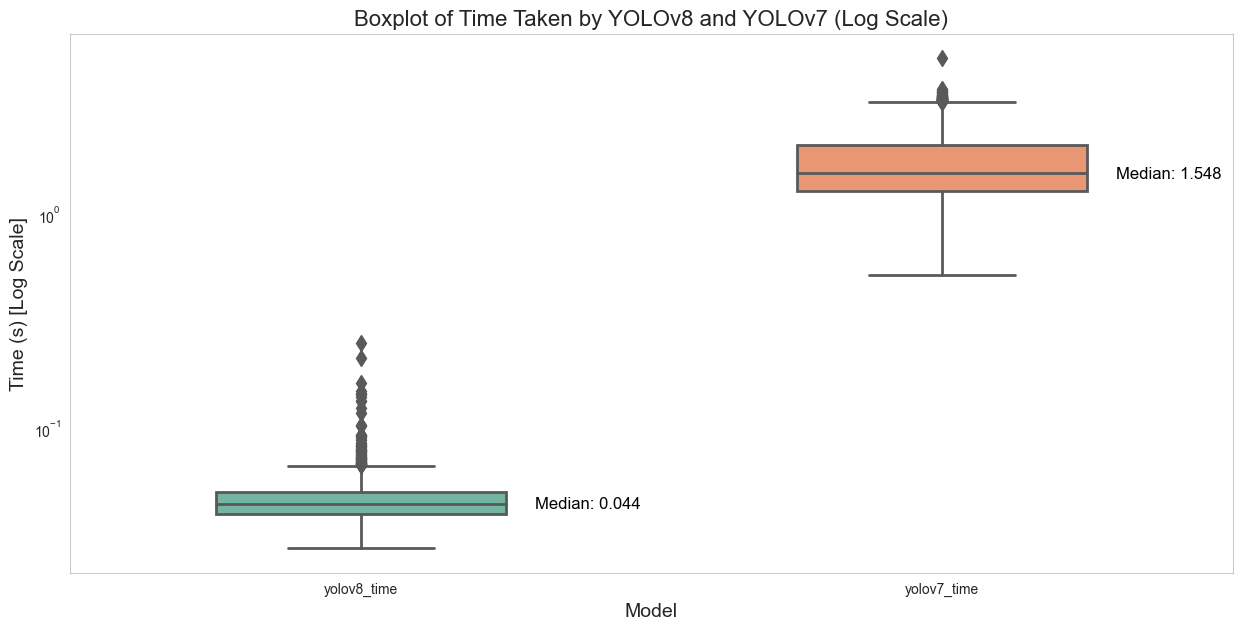

In [7]:
# Boxplot with Median Annotation on the Side
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid") 
sns.set_palette("Set2") 

sns.boxplot(data=df[['yolov8_time', 'yolov7_time']], width=0.5, fliersize=8, linewidth=2)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Time (s) [Log Scale]', fontsize=14)
plt.title('Boxplot of Time Taken by YOLOv8 and YOLOv7 (Log Scale)', fontsize=16)

# We set y-axis to logarithmic scale
plt.yscale("log")

plt.grid(axis='y')

# We annotate median values on the side for better context
medians = df[['yolov8_time', 'yolov7_time']].median()
for i, median in enumerate(medians):
    plt.text(i + 0.3, median, f"Median: {round(median, 3)}", 
             horizontalalignment='left', verticalalignment='center', fontsize=12, color='black')

plt.show()
